In [1]:
import pandas as pd
import os
from glob import glob
import json
from pandarallel import pandarallel
import re

pandarallel.initialize(nb_workers=10, progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
audio_dir = "/data/audio_data/prep_submission_audio/10/"
metadata_path="/data/audio_data/pronunciation_scoring_result/info_question_type-10_01082023_18092023.csv"
metadata = pd.read_csv(metadata_path)
metadata.dropna(inplace=True)
metadata.head()

,id,is_deleted,user_id,question_id,question_type,question_content,url,score,fidelity_class,created_at,total_time,word_count
0,5580000,0,52077.0,66902,10,statistics,https://storage.googleapis.com/materials-eleme...,90.00,RELEVANT,2023-09-18 21:17:11,2.63,1.0
1,5580001,0,88226.0,26144,10,Seat,https://storage.googleapis.com/materials-eleme...,53.00,RELEVANT,2023-09-18 21:17:11,2.45,1.0
2,5580002,0,63452.0,107048,10,Keep your body in shape,https://storage.googleapis.com/materials-eleme...,67.46,RELEVANT,2023-09-18 21:17:12,3.05,5.0
3,5580003,0,199169.0,10273,10,Foggy,https://storage.googleapis.com/materials-eleme...,80.00,RELEVANT,2023-09-18 21:17:12,1.86,1.0
4,5580004,0,237799.0,23683,10,School,https://storage.googleapis.com/materials-eleme...,69.00,RELEVANT,2023-09-18 21:17:13,1.80,1.0


In [3]:
metadata = metadata[metadata.fidelity_class == "RELEVANT"]

In [4]:
def check_audio_is_exist(audio_id):
    abs_path = os.path.join(audio_dir, f'{audio_id}.wav')
    if os.path.exists(abs_path):
        return True
    return False

metadata["is_exist"] =  metadata.id.parallel_apply(check_audio_is_exist)
metadata = metadata[metadata["is_exist"] == True]

### decision visualiz

In [5]:
def extract_decision(json_path):
    try:
        with open(json_path, "r") as f:
            raw_sample = json.load(f)
        if "api_version" not in raw_sample:
            return None
        
        assert len(raw_sample["utterance"]) == 1
        return raw_sample["utterance"][0]["decision"]
    except:
        return None
    
json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/10"
metadata["decision"] = metadata.id.parallel_apply(lambda x: extract_decision(os.path.join(json_dir, f'{x}.json')))

In [6]:
def extract_phone_score(json_path):
    try:
        with open(json_path, "r") as f:
            raw_sample = json.load(f)
        if "api_version" not in raw_sample:
            return None
        
        assert len(raw_sample["utterance"]) == 1
        phonemes = []

        for word in raw_sample["utterance"][0]["words"]:
            for phoneme in word["phonemes"]:
                phonemes.append(phoneme["nativeness_score"])

        return phonemes
    except:
        return None
    
json_dir = "/data/audio_data/pronunciation_scoring_result/marking_data/10"
metadata["phone_score"] = metadata.id.parallel_apply(lambda x: extract_phone_score(os.path.join(json_dir, f'{x}.json')))

In [8]:
metadata = metadata.explode("phone_score")

In [12]:
metadata[metadata["decision"] == "almost_correct"].phone_score.value_counts()

phone_score
100    2127061
99     1576252
0      1226931
98     1225704
97      987350
        ...   
73       15996
74       15981
71       15734
63       15318
75       14580
Name: count, Length: 101, dtype: int64

In [13]:
truncate = metadata[metadata["decision"] == "almost_correct"].phone_score.value_counts() < 10000
truncate = truncate[truncate==False]

<Axes: >

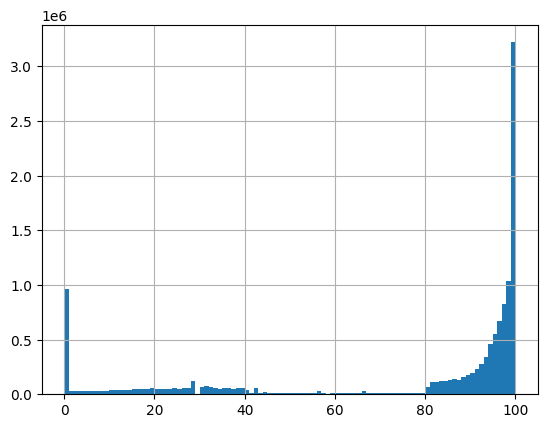

In [15]:
metadata[(metadata["decision"] == "almost_correct") & (~metadata.score.isin(set(truncate.index.to_list())))].phone_score.hist(bins=100)

In [ ]:
metadata[metadata["decision"] == "almost_correct"].score.hist(bins=10000)

In [18]:
metadata[metadata["decision"] == "correct"].score.value_counts()

score
97.00    178484
96.00    171716
98.00    163715
95.00    155286
94.00    134036
          ...  
99.67         9
99.55         8
99.80         8
99.91         8
99.63         6
Name: count, Length: 1968, dtype: int64

In [19]:
truncate = metadata[metadata["decision"] == "correct"].score.value_counts() < 10000
truncate = truncate[truncate==False]

In [20]:
metadata[(metadata["decision"] == "correct") & (~metadata.score.isin(set(truncate.index.to_list())))].id.nunique()

114721

In [ ]:
print(metadata[metadata["decision"] == "correct"].score.value_counts())

<Axes: >

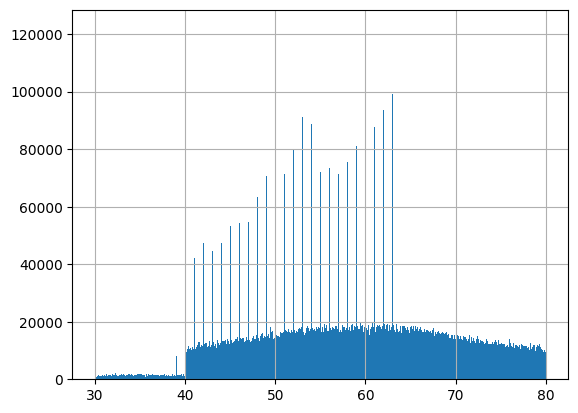

In [24]:
metadata[metadata["decision"] == "almost_correct"].score.hist(bins=1000)

<Axes: >

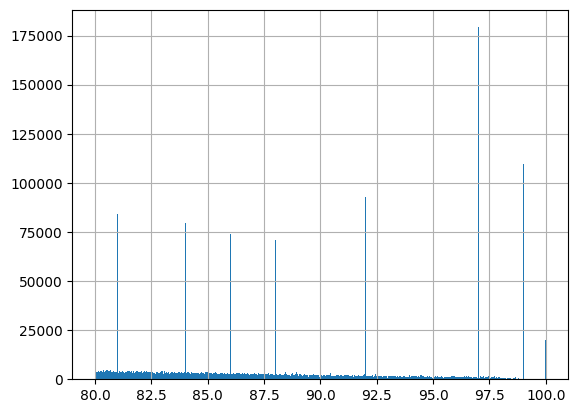

In [23]:
metadata[metadata["decision"] == "correct"].score.hist(bins=1000)

<Axes: >

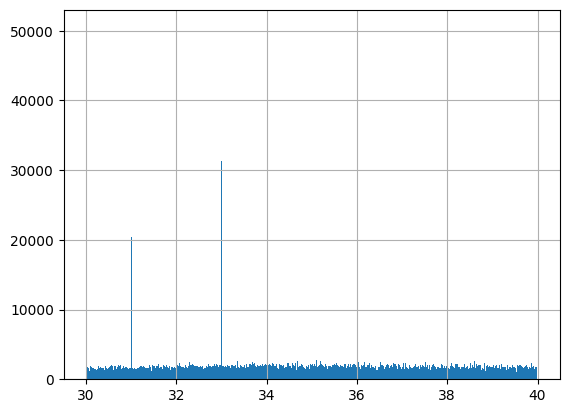

In [22]:
metadata[metadata["decision"] == "incorrect"].score.hist(bins=1000)

In [ ]:
metadata.explode("phone_score").phone_score.hist(bins=100)

In [ ]:
metadata[metadata.phone_score < 0]

In [ ]:
metadata.phone_score.hist(bins=100)

In [ ]:
metadata[metadata.phone_score < 90].phone_score.hist(bins=200)

In [2]:
import os
import numpy as np
from glob import glob

In [5]:
path = "tmp/prep/"
n = int(len(glob(f'{path}/*.npy')) / 2)
labels, features = [], []
for i in range(0, n):
    feat_path = os.path.join(path, f'tr_feat_{i}.npy')
    feat = np.load(feat_path)

    label_path = os.path.join(path, f'tr_label_{i}.npy')
    label = np.load(label_path)

    labels.append(label)
    features.append(feat)

In [12]:
features = np.concatenate(features)
labels = np.concatenate(labels)